# Data Science project: CIRI

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from tqdm import tqdm
from enum import Enum
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Parameters

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [2]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [3]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the images were pre-processed in another notebook, they must now be loaded into this one. To do so, we use a custom class taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [4]:
class prepped_data(torch.utils.data.Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

In [5]:
data = {}
for i in tqdm(range(5)):
    data[i] = prepped_data(
        f"./content/fold{i}_loader/img",
        f"./content/fold{i}_loader/target"
    )

with open("./content/data_classes.bin", "rb") as file:
    data_classes = pickle.load(file)

100%|██████████| 5/5 [00:00<00:00, 689.42it/s]


In [6]:
class DataType(Enum):
    TRAIN = "train"
    TEST = "test"


class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object to reduce the need to pass
    high numbers of parameters.
    """

    def __init__(self, data, classes):
        """
        Keyword arguments:
        data   -- dictionary of dataset labels mapped to corresponding Datasets
        classes -- a list of all classes that exist in the Datasets
        """
        self.data = data
        self.all_classes = classes

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in tqdm(self.data.items()):
            self.dataloaders[label] = DataLoader(
                data,
                batch_size=4,
                shuffle=False
            )

    def _get_targets(self, data):
        return [target for (_, target) in data]


dataset = Dataset(data, data_classes)

100%|██████████| 5/5 [00:00<00:00, 4476.31it/s]


## Initialize models

In [7]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """

    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs


models = []
if cuda_enabled:
    torch.cuda.empty_cache()

### VGG16

In [8]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [9]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

### RESNET 50

In [10]:
class Resnet50Model(Model):
    def __init__(self):
        model = torchvision.models.resnet50(weights="DEFAULT")
        super().__init__(model, "Resnet50")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


resnet = Resnet50Model()
resnet.to(device)

models.append(resnet)

## Baseline

### Obtain image descriptors

In [11]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """

    def __init__(self, model, base_path="./data/descriptors"):
        self.model = model
        self.base_path = base_path
        self.descriptors = {}

    def _create_path(self, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{self.model.name}/descriptors_{label}.bin"

    def save_descriptors(self, descriptors, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self._create_path(label)
        os.makedirs(os.path.dirname(path), exist_ok=True)

        with open(path, "wb") as file:
            pickle.dump(descriptors, file)

    def extract_descriptors(self, dataloader, label):
        """
        Extracts descriptors from the provided model and saves them to this
        DescriptorManager.
        """
        descriptors = self.model.descriptors(dataloader, True)
        self.descriptors[label] = descriptors

        return descriptors

    def load_descriptors(self, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self._create_path(label)

        with open(path, "rb") as file:
            self.descriptors[label] = pickle.load(file)

            return self.descriptors[label]

    def get_descriptors(self, dataloader, label):
        """
        Returns cached descriptors, returns descriptors from the file system or
        extracts and saves new descriptors from the model, based on which is
        available.

        Keyword arguments:
        dataloader -- DataLoader with data for which descriptors are retrieved
        label -- the label for this data (e.g. "train", "test", "fold1", etc.)
        """
        if label in self.descriptors:
            return self.descriptors[label]

        try:
            return self.load_descriptors(label)
        except FileNotFoundError:
            descriptors = self.extract_descriptors(dataloader, label)
            self.save_descriptors(descriptors, label)

            return descriptors

### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [12]:
n_neighbors_list = [2, 5, 10, 15, 20, 30, 40, 50, 75, 100]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [13]:
class DescriptorAssessor:
    def __init__(self, descriptor_manager):
        self.descriptor_manager = descriptor_manager

    def _get_descriptors(self, dataset, data_types):
        descriptors = []

        for data_type in data_types:
            descriptors.append(self.descriptor_manager.get_descriptors(
                dataset.dataloaders[data_type],
                data_type
            ))

        return np.concatenate(descriptors)

    def _assess_fold_for_neighbors(
        self,
        train_descriptors,
        train_targets,
        test_descriptors,
        test_targets,
        n_neighbors
    ):
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
            train_descriptors,
            train_targets
        )

        test_predictions = classifier.predict(test_descriptors)

        accuracy = accuracy_score(test_targets, test_predictions)
        precision = precision_score(
            test_targets,
            test_predictions,
            average="macro",
            zero_division=0
        )
        f1 = f1_score(test_targets, test_predictions, average="macro")

        return test_predictions, accuracy, precision, f1

    def assess_kfold(self, dataset, n_neighbors_list):
        all_targets = {}
        fold_sizes = {}

        all_predictions = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_accuracies = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_precisions = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_f1_scores = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )

        folds = list(dataset.data.keys())

        for test_fold in dataset.data.keys():
            train_folds = folds.copy()
            train_folds.remove(test_fold)

            train_descriptors = self._get_descriptors(dataset, train_folds)
            test_descriptors = self._get_descriptors(dataset, [test_fold])

            train_targets = np.concatenate(
                [dataset.targets[train_fold] for train_fold in train_folds]
            )
            test_targets = dataset.targets[test_fold]

            all_targets[test_fold] = test_targets
            fold_sizes[test_fold] = len(test_targets)

            for n_neighbors in n_neighbors_list:
                (
                    predictions,
                    accuracy,
                    precision,
                    f1_score
                ) = self._assess_fold_for_neighbors(
                    train_descriptors,
                    train_targets,
                    test_descriptors,
                    test_targets,
                    n_neighbors
                )

                all_predictions[n_neighbors][test_fold] = predictions
                all_accuracies[n_neighbors][test_fold] = accuracy
                all_precisions[n_neighbors][test_fold] = precision
                all_f1_scores[n_neighbors][test_fold] = f1_score

        accuracy_n = {}
        total_weight = 0
        total_accuracy = 0
        for n_neighbors, test_fold_accuracies in all_accuracies.items():
            for test_fold, fold_accuracy in test_fold_accuracies.items():
                weight = fold_sizes[test_fold]
                total_accuracy += fold_accuracy * weight
                total_weight += weight
            accuracy_n[n_neighbors] = total_accuracy / total_weight

        precision_n = {}
        total_weight = 0
        total_precision = 0
        for n_neighbors, test_fold_precisions in all_precisions.items():
            for test_fold, fold_precision in test_fold_precisions.items():
                weight = fold_sizes[test_fold]
                total_precision += fold_precision * weight
                total_weight += weight
            precision_n[n_neighbors] = total_precision / total_weight

        f1_score_n = {}
        total_weight = 0
        total_f1_score = 0
        for n_neighbors, test_fold_f1_scores in all_f1_scores.items():
            for test_fold, fold_f1_score in test_fold_f1_scores.items():
                weight = fold_sizes[test_fold]
                total_f1_score += fold_f1_score * weight
                total_weight += weight
            f1_score_n[n_neighbors] = total_f1_score / total_weight

        return (all_targets, all_predictions, accuracy_n, precision_n, f1_score_n)

In [14]:
class Visualiser:
    def __init__(self, model):
        self.model = model

    def _print_accuracies(self, accuracies):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy for {n_neighbors}-neighbor classification: {accuracy}")

    def _plot_metric(self, ax, metric, label):
        return ax.plot(
            metric.keys(),
            list(metric.values()),
            label=label,
            marker="o"
        )

    def visualise_metrics_per_n(self, accuracies, precisions, f1_scores):
        fig, ax = plt.subplots()

        self._print_accuracies(accuracies)
        self._plot_metric(ax, accuracies, "accuracy")
        self._plot_metric(ax, precisions, "precision (macro-average)")
        self._plot_metric(ax, f1_scores, "f1_score (macro-average)")

        ax.legend()
        ax.set_title(f"kNN-classification performance using {self.model.name} descriptors")
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("score")
        plt.show()

VGG16 accuracy for 2-neighbor classification: 0.3499809741248097
VGG16 accuracy for 5-neighbor classification: 0.3336187214611872
VGG16 accuracy for 10-neighbor classification: 0.31452942668696093
VGG16 accuracy for 15-neighbor classification: 0.2965896118721461
VGG16 accuracy for 20-neighbor classification: 0.2816780821917808
VGG16 accuracy for 30-neighbor classification: 0.26767820903094874
VGG16 accuracy for 40-neighbor classification: 0.25506903674711895
VGG16 accuracy for 50-neighbor classification: 0.2436263318112633
VGG16 accuracy for 75-neighbor classification: 0.2310586842550313
VGG16 accuracy for 100-neighbor classification: 0.21912100456621006


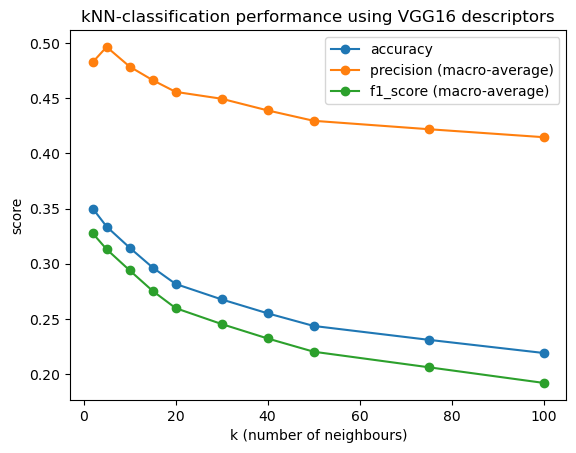

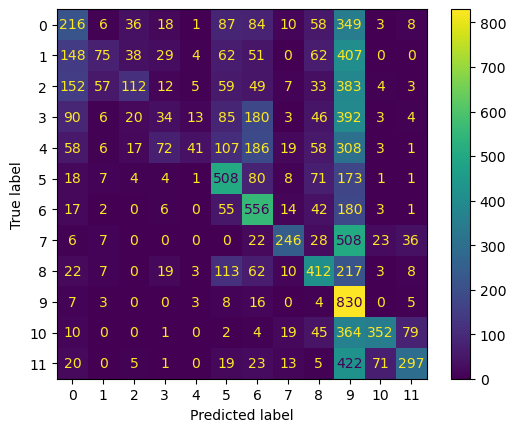

InceptionV3 accuracy for 2-neighbor classification: 0.5964611872146118
InceptionV3 accuracy for 5-neighbor classification: 0.6116343226788432
InceptionV3 accuracy for 10-neighbor classification: 0.6240804160324708
InceptionV3 accuracy for 15-neighbor classification: 0.631183409436834
InceptionV3 accuracy for 20-neighbor classification: 0.6367579908675799
InceptionV3 accuracy for 30-neighbor classification: 0.6395230847285642
InceptionV3 accuracy for 40-neighbor classification: 0.6404245488149598
InceptionV3 accuracy for 50-neighbor classification: 0.640625
InceptionV3 accuracy for 75-neighbor classification: 0.6393222560460003
InceptionV3 accuracy for 100-neighbor classification: 0.6371480213089802


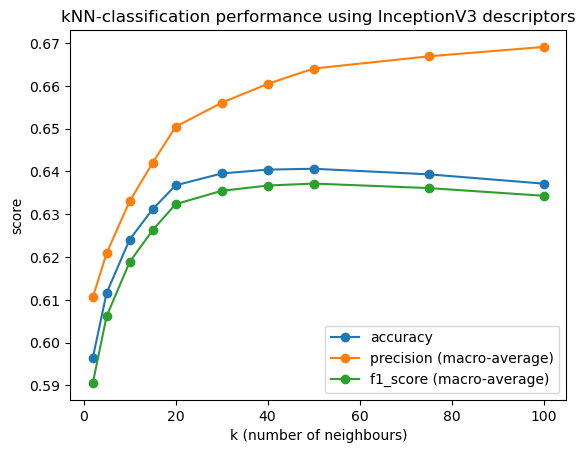

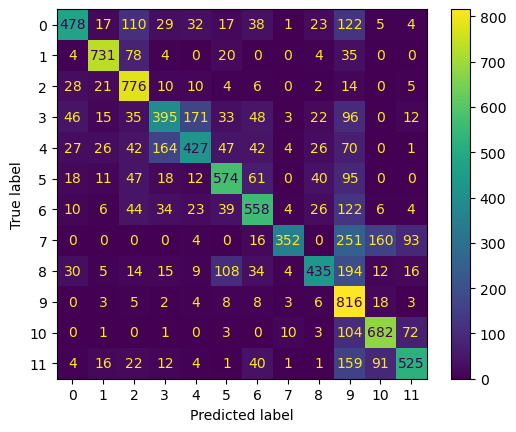

Resnet50 accuracy for 2-neighbor classification: 0.723744292237443
Resnet50 accuracy for 5-neighbor classification: 0.73087899543379
Resnet50 accuracy for 10-neighbor classification: 0.7381088280060882
Resnet50 accuracy for 15-neighbor classification: 0.7442446727549468
Resnet50 accuracy for 20-neighbor classification: 0.7469368340943684
Resnet50 accuracy for 30-neighbor classification: 0.7470034246575342
Resnet50 accuracy for 40-neighbor classification: 0.7460589258534464
Resnet50 accuracy for 50-neighbor classification: 0.7444349315068494
Resnet50 accuracy for 75-neighbor classification: 0.7411212582445459
Resnet50 accuracy for 100-neighbor classification: 0.7369292237442923


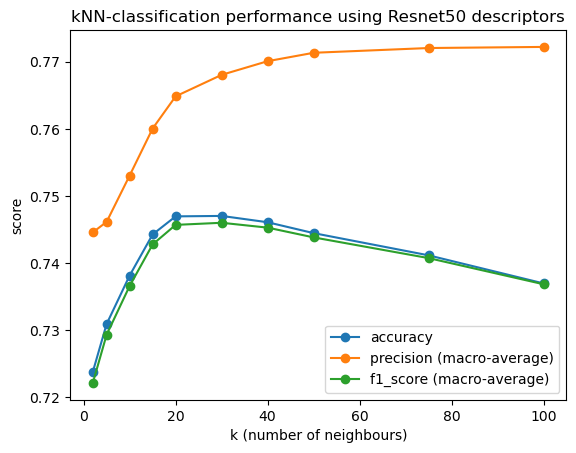

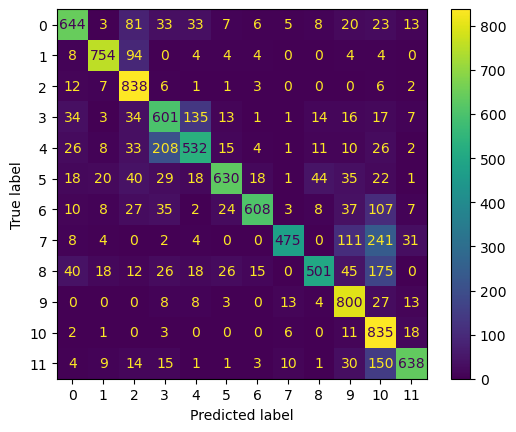

In [15]:
for model in models:
    descriptor_manager = DescriptorManager(model)
    descriptor_assessor = DescriptorAssessor(descriptor_manager)

    targets, predictions, accuracies, precisions, f1_scores = descriptor_assessor.assess_kfold(
        dataset,
        n_neighbors_list
    )

    visualiser = Visualiser(model)
    visualiser.visualise_metrics_per_n(
        accuracies,
        precisions,
        f1_scores
    )

    best_n_test = max(
        accuracies,
        key=accuracies.get
    )

    cm = confusion_matrix(
        np.concatenate(list(targets.values())),
        np.concatenate(list(predictions[best_n_test].values()))
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Visually assess predicted vs. target through PCA

In [16]:
def plot_predictions_against_targets(fit_pca,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)